In [47]:
import torch
from data_utils import GuidedGridMLMDataset, GuidedGridMLM_collate_fn
from torch.utils.data import DataLoader
from GridMLM_tokenizers import GuidedGridMLMTokenizer
from models import GuidedMLMH
from tqdm import tqdm
import numpy as np

In [48]:
device_name = 'cuda:0'
val_dir = '/media/maindisk/data/hooktheory_hr/hooktheory_CA_test'
jazz_dir = '/media/maindisk/data/gjt_melodies/gjt_CA'
subfolder = 'CA'
curriculum_type='random'
ablation = 'all'

In [49]:
model_path = 'saved_models/' + subfolder + '/' + curriculum_type + '_' + ablation + '.pt'
tokenizer = GuidedGridMLMTokenizer(fixed_length=256)
val_dataset = GuidedGridMLMDataset(val_dir, tokenizer, 512, frontloading=True)
jazz_dataset = GuidedGridMLMDataset(jazz_dir, tokenizer, 512, frontloading=True)

Loading data file.
Loading data file.


In [50]:
if device_name == 'cpu':
        device = torch.device('cpu')
else:
    if torch.cuda.is_available():
        device = torch.device(device_name)
    else:
        print('Selected device not available: ' + device_name)
vae_cfg = {
    'input_dim': 512,
    'hidden_dim': 256,
    'latent_dim': 128,
    'embedding_dim': 64,
    'seq_len': 256,
    'feature_dim': 37,
}
encoder_cfg = {
    'nhead': 8,
    'num_layers': 8,
    'stage_embedding_dim': 64,
    'max_stages': 10
}
model = GuidedMLMH(
    vae_cfg=vae_cfg,
    encoder_cfg=encoder_cfg,
    chord_vocab_size=len(tokenizer.vocab),
    d_model=512,
    conditioning_dim=16,
    pianoroll_dim=100,
    grid_length=256,
    guidance_dim=128,
    unfold_latent=True,
    device=device,
)
checkpoint = torch.load(model_path, map_location=device_name)
model.load_state_dict(checkpoint)
model.eval()
model.to(device)

GuidedMLMH(
  (condition_proj): Linear(in_features=16, out_features=512, bias=True)
  (melody_proj): Linear(in_features=100, out_features=512, bias=True)
  (harmony_embedding): Embedding(354, 512)
  (guidance_to_dmodel): Linear(in_features=128, out_features=512, bias=True)
  (vae): GuidanceVAE(
    (embedding): Embedding(354, 64)
    (encoder_rnn): LSTM(64, 256, batch_first=True)
    (mu_proj): Linear(in_features=256, out_features=128, bias=True)
    (logvar_proj): Linear(in_features=256, out_features=128, bias=True)
    (decoder_rnn): LSTM(128, 256, batch_first=True)
    (recon_proj): Linear(in_features=256, out_features=354, bias=True)
    (feature_proj): Linear(in_features=128, out_features=37, bias=True)
  )
  (encoder): GridMLMMelHarmEncoder(
    (stage_embedding): Embedding(10, 64)
    (stage_proj): Linear(in_features=576, out_features=512, bias=True)
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-7): 8 x TransformerEncoderLayer(
          (self_attn): 

In [51]:
def condenced_str_from_token_ids(inp_ids, tokenizer):
    # for computing features
    chord_type_distribution = [0]*len(tokenizer.qualities)
    chord_duration_distribution = [0]*8 # for 1, 2, 4, 8, 16, ... 128 consecutive occurances
    tmp_str = ''
    tmp_count = 0
    prev_id = -1
    num_chords = 0
    for t in inp_ids:
        if prev_id == t:
            tmp_count += 1
        else:
            if prev_id != -1:
                chord_token = tokenizer.ids_to_tokens[prev_id]
                tmp_str += f'{tmp_count}x{chord_token}'
                if chord_token != '<nc>' and chord_token != '<pad>':
                    if ':' in chord_token:
                        type_token = chord_token.split(':')[1]
                    else:
                        type_token = ''
                    # update chord type distribution
                    type_idx = tokenizer.qualities.index(type_token)
                    chord_type_distribution[ type_idx ] += 1
                    # update chord duration distribution
                    chord_duration_distribution[ min( int(np.log2(tmp_count)), 7 ) ] += 1
                num_chords += 1
                if num_chords == 4:
                    tmp_str += '\n'
                    num_chords = 0
                else:
                    tmp_str += '_'
            tmp_count = 1
            prev_id = t
    chord_token = tokenizer.ids_to_tokens[prev_id]
    tmp_str += f'{tmp_count}x{chord_token}'
    if chord_token != '<nc>' and chord_token != '<pad>':
        if ':' in chord_token:
            type_token = chord_token.split(':')[1]
        else:
            type_token = ''
        # update chord type distribution
        type_idx = tokenizer.qualities.index(type_token)
        chord_type_distribution[ type_idx ] += 1
        # update chord duration distribution
        chord_duration_distribution[ min( int(np.log2(tmp_count)), 7 ) ] += 1
    # normalize features
    s_tmp = sum(chord_type_distribution)
    if s_tmp > 0:
        for i in range(len(chord_type_distribution)):
            chord_type_distribution[i] /= s_tmp
    s_tmp = sum(chord_duration_distribution)
    if s_tmp > 0:
        for i in range(len(chord_duration_distribution)):
            chord_duration_distribution[i] /= s_tmp
    return tmp_str, chord_type_distribution + chord_duration_distribution
# end condenced_str_from_token_ids

zs = []
z_idxs = []
z_tokens = []
feats = []
feats_from_str = []
for d in tqdm(val_dataset):
    full_harmony = torch.tensor(d['input_ids']).reshape(1, len(d['input_ids']))
    tmp_str, tmp_feats = condenced_str_from_token_ids(d['input_ids'], tokenizer)
    z_tokens.append(tmp_str)
    z = model.get_z_from_harmony(full_harmony.to(device)).detach().cpu()[0].tolist()
    zs.append(z)
    z_idxs.append(0)
    feats.append(d['features'])
    feats_from_str.append( tmp_feats )
for d in tqdm(jazz_dataset):
    full_harmony = torch.tensor(d['input_ids']).reshape(1, len(d['input_ids']))
    tmp_str, tmp_feats = condenced_str_from_token_ids(d['input_ids'], tokenizer)
    z_tokens.append(tmp_str)
    z = model.get_z_from_harmony(full_harmony.to(device)).detach().cpu()[0].tolist()
    zs.append(z)
    z_idxs.append(1)
    feats.append(d['features'])
    feats_from_str.append( tmp_feats )

100%|██████████| 547/547 [00:02<00:00, 255.15it/s]


In [52]:
print(z_tokens[10])

198xA:min_6xG#:dim_6xG:5_6xF#:min
4xF:maj_4xE:maj_16xF:maj_16x<pad>


In [53]:
print(feats[0])
print(feats_from_str[0])

[0.5091859540384744, 0.17492942272279063, 0.0, 1.096288752711381e-81, 0.0, 9.398507544996096e-05, 6.943010495685772e-14, 1.6298146703487725e-16, 1.1304429187100833e-10, 0.0, 0.0, 5.609521673e-314, 0.0, 1.6298146703487725e-16, 6.246186297125563e-163, 1.1639004632323842e-06, 3.2617709368788e-178, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.31578947414970776, 0.0, 0.0, 0.0, 0.0, 0.0, 3.113773628667366e-22, 0.30000548266336663, 9.424758305961007e-05, 0.32927137378590604, 0.3706288959676677, 4.300899824531482e-18, 0.0, 1.4451365097210327e-241]
[0.5, 0.25, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.5, 0.0, 0.0, 0.0]


In [54]:
feats_np = np.array(feats_from_str)

In [55]:
print(feats_np.shape)

(1027, 37)


In [56]:
z_np = np.array( zs )

In [57]:
print(z_np.shape)

(1027, 128)


In [58]:
# from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [59]:
# y = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3, verbose=2).fit_transform(z_np)
pca = PCA(n_components=2)
# y = pca.fit_transform( z_np )
y = pca.fit_transform( feats_np )

In [60]:
print(y.shape)

(1027, 2)


In [61]:
import matplotlib.pyplot as plt

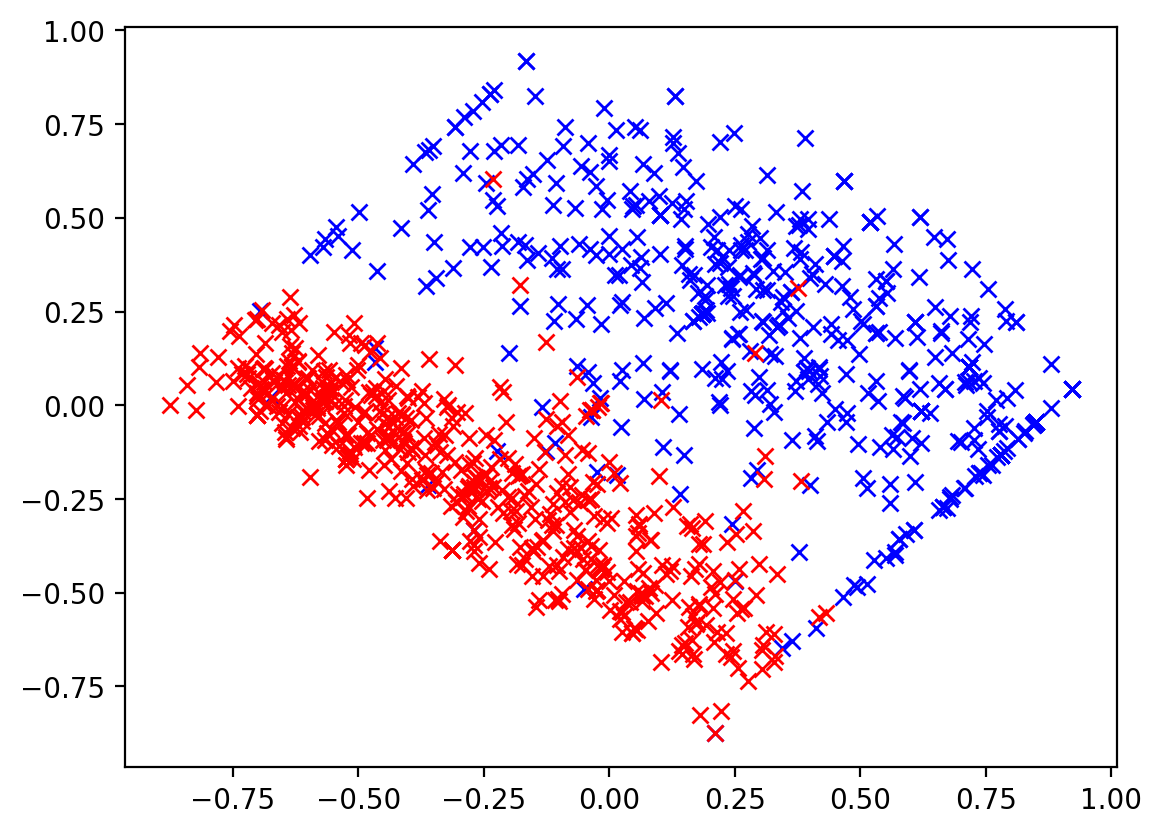

In [62]:
plt.plot(y[:len(val_dataset),0], y[:len(val_dataset),1], 'bx')
plt.plot(y[len(val_dataset):,0], y[len(val_dataset):,1], 'rx')

In [63]:
import numpy as np
import plotly.express as px
import pandas as pd

custom_colors = ['#1f77b4', '#ff7f0e']  # blue and orange

# Example inputs (replace with your actual data)
# z_tsne: Nx2 array
# z_idxs: list of ints (classes)
# z_tokens: list of strings

# Combine into a DataFrame for easy Plotly integration
df = pd.DataFrame({
    'x': y[:, 0],
    'y': y[:, 1],
    'class': z_idxs,
    'token': z_tokens
})

df['hover_text'] = df['token'].str.replace('\n', '<br>')
df['class_str'] = df['class'].astype(str)

# Create interactive scatter plot
fig = px.scatter(
    df,
    x='x',
    y='y',
    color='class_str',
    hover_data=None,
    color_discrete_sequence=custom_colors
    # hover_name='token',  # This will show on hover
    # title='2D Visualization',
)

fig.update_layout(
    xaxis=dict(scaleanchor='y', scaleratio=1),  # Equal aspect ratio
)

fig.update_traces(
    hovertemplate=df['hover_text']
)

# Show the figure in notebook
fig.show()
